# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the MNIST dataset. 

>The encoder portion will be made of convolutional and pooling layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or other kinds of reconstruction and transformation!

<img src='notebook_ims/denoising.png' width=60%/>

Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

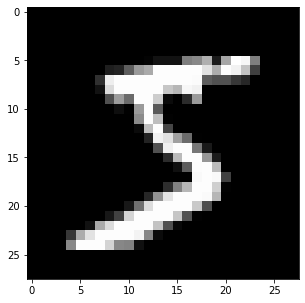

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. 

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation. A schematic of the network is shown below.

<img src='notebook_ims/conv_enc_1.png' width=640px>

Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, in fact, you're encouraged to add additional layers to make this representation even smaller! Remember our goal here is to find a small representation of the input data.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d). 

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. 

> We'll show this approach in another notebook, so you can experiment with it and see the difference.


#### TODO: Build the network shown above. 
> Build the encoder out of a series of convolutional and pooling layers. 
> When building the decoder, recall that transpose convolutional layers can upsample an input by a factor of 2 using a stride and kernel_size of 2. 

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    ''' Note that in this implementatio we will always assume kernel size provided 
    by the user to be an odd number. If this is not true, then kernel size will reduced 
    to the largest odd number smaller than the input kernel size '''
    def __init__(self, kernel_size = 3):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        
        if kernel_size%2 == 0:
            print('Input value for kernel size is NOT odd')
            print('Choosing kernel size to be the largest odd number smaller than the input value')
            print('Input value: {}, Chosen value: {}'.format(kernel_size, kernel_size -1))
            kernel_size -=1
        padding = int(kernel_size/2)
        
        self.l1 = nn.Conv2d(1,16,kernel_size = kernel_size, padding = padding, stride = 1)
        self.l2 = nn.MaxPool2d(kernel_size = 2) # note that downsampling happens only when the stride is non-trivial
                                                # so in principle, just setting the kernel_size = 2 does NOT reduce 
                                                # the size of the input feature maps to the maxpool layer
                                                # we should ideally set stride >= 2 for downsampling
                                                # however, in pytorch, the default stride for maxpool layers is set to be
                                                # same as kernel size. Thus just setting kernel_size = 2 for 
                                                # MaxPool2d works fine in the present case
                            
        self.l3 = nn.Conv2d(16, 4, kernel_size = kernel_size, padding = padding, stride = 1)
        self.l4 = nn.MaxPool2d(kernel_size = 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        
        # for transpose convolutional kernel the easiest way to ensure doubling of size 
        # is to choose even valued kernel_size 
        kernel_size = kernel_size -1
        # appropriate padding to make sure that the output feature map is double the size of the input feature map
        padding = int(kernel_size/2)-1
        
        self.t_conv1 = nn.ConvTranspose2d(4, 16, kernel_size = kernel_size, 
                                          padding = padding, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16,1, kernel_size = kernel_size, 
                                          padding = padding, stride = 2)


    def forward(self, x):
        ## encode ##
        # print(x.size())
        x = self.l1(x)
        # print('l1: {}'.format(x.size()))
        x = F.relu(self.l2(x))
        # print('l2: {}'.format(x.size()))
        x = self.l3(x)
        # print('l3: {}'.format(x.size()))
        x = F.relu(self.l4(x))   
        # print('l4: {}'.format(x.size()))
        
        ## decode ##
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        x = F.relu(self.t_conv1(x))
        # print('t_conv1: {}'.format(x.size()))
        x = torch.sigmoid(self.t_conv2(x))
        
        
                
        return x

# initialize the NN
model_k3 = ConvAutoencoder()
model_k5 = ConvAutoencoder(kernel_size = 5)
print('model_k3:\n', model_k3)
print('\nmodel_k5:\n', model_k5)

model_k3:
 ConvAutoencoder(
  (l1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

model_k5:
 ConvAutoencoder(
  (l1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l3): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images _do not_ need to be flattened before being passed in an input to our model.

In [5]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer_k3 = torch.optim.Adam(model_k3.parameters(), lr=0.001)
optimizer_k5 = torch.optim.Adam(model_k5.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss_k3 = 0.0
    train_loss_k5 = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer_k3.zero_grad()
        optimizer_k5.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs_k3 = model_k3(images)
        outputs_k5 = model_k5(images)
        # calculate the loss
        loss_k3 = criterion(outputs_k3, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss_k3.backward()
        # perform a single optimization step (parameter update)
        optimizer_k3.step()
        # update running training loss
        train_loss_k3 += loss_k3.item()*images.size(0)
        
        # loss of model_k5
        loss_k5 = criterion(outputs_k5, images)
        # backwards pass
        loss_k5.backward()
        # optimizer step
        optimizer_k5.step()
        # training loss
        train_loss_k5 +=loss_k5.item()*images.size(0)
            
    # print avg training statistics 
    print('\nEpoch: {}'.format(epoch))
    train_loss_k3 = train_loss_k3/len(train_loader)
    print('model_k3: \tTraining Loss: {:.6f}'.format(train_loss_k3))
    train_loss_k5 = train_loss_k5/len(train_loader)
    print('model_k5: \tTraining Loss: {:.6f}'.format(train_loss_k5))


Epoch: 1
model_k3: 	Training Loss: 0.424763
model_k5: 	Training Loss: 2.261162

Epoch: 2
model_k3: 	Training Loss: 0.275871
model_k5: 	Training Loss: 2.240052

Epoch: 3
model_k3: 	Training Loss: 0.254899
model_k5: 	Training Loss: 2.240051

Epoch: 4
model_k3: 	Training Loss: 0.241122
model_k5: 	Training Loss: 2.240051

Epoch: 5
model_k3: 	Training Loss: 0.232749
model_k5: 	Training Loss: 2.240051

Epoch: 6
model_k3: 	Training Loss: 0.225808
model_k5: 	Training Loss: 2.240051

Epoch: 7
model_k3: 	Training Loss: 0.218949
model_k5: 	Training Loss: 2.240051

Epoch: 8
model_k3: 	Training Loss: 0.214396
model_k5: 	Training Loss: 2.240051

Epoch: 9
model_k3: 	Training Loss: 0.211002
model_k5: 	Training Loss: 2.240051

Epoch: 10
model_k3: 	Training Loss: 0.207741
model_k5: 	Training Loss: 2.240051

Epoch: 11
model_k3: 	Training Loss: 0.205037
model_k5: 	Training Loss: 2.240051

Epoch: 12
model_k3: 	Training Loss: 0.202859
model_k5: 	Training Loss: 2.240051

Epoch: 13
model_k3: 	Training Loss: 

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

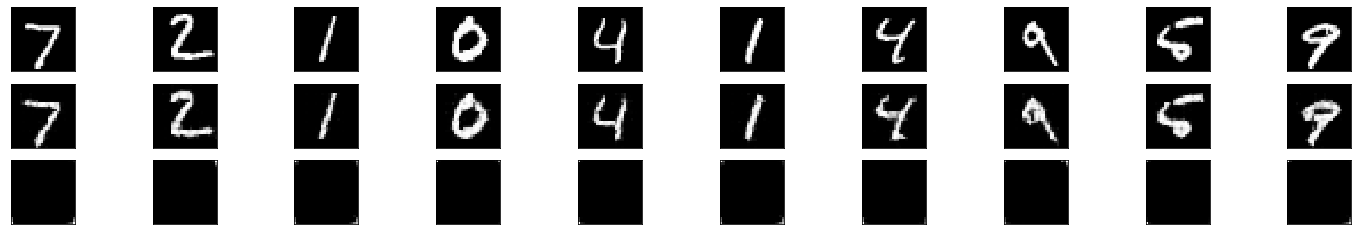

In [7]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output_k3 = model_k3(images)
output_k5 = model_k5(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output_k3 = output_k3.view(batch_size, 1, 28, 28)
output_k5 = output_k5.view(batch_size, 1, 28,28)
# use detach when it's an output that requires_grad
output_k3 = output_k3.detach().numpy()
output_k5 = output_k5.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output_k3, output_k5], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

We trained two autoencoders above. The first one used 3 x 3 kernel in the encoder and 2 x 2 kernels in the decoder. The second model used 5 x 5 kernels in the encoder and 4 x 4 kernels in the decoder. Turns out the second model totally failed to train. This can be seen from the fact that its training loss does not decrease after the 3rd epoch. This can also be seen in the images produced by it (see images in the last row above) which are completely blank. I suspect that this is because the 5 x 5 kernels are too big for the starting image. As the results, they wrangle the information in the images beyond recognition by the time we reach the last layer of the encoder whose feature maps having a 7x7 size are barely larger than the kernels themselves. I think the 5 x 5 kernels would have been fine on larger images.

## Encoder with upsampling and convolutional layers

Let us now replace the transpose convolution layers by upsampling+convolution layers in the model.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class autoencoder(nn.Module):
    def __init__(self, kernel_size = 3):
        super().__init__()
        
        padding = int(kernel_size/2)
        # encoder
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size = kernel_size, padding = padding)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 4, kernel_size = kernel_size, padding = padding)
        
        # decoder
        self.conv3 = nn.Conv2d(4, 16, kernel_size = kernel_size, padding = padding)
        self.conv4 = nn.Conv2d(16, 1, kernel_size = kernel_size, padding = padding )
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.pool(x))
        x = self.conv2(x)
        x = F.relu(self.pool(x))
        x = F.interpolate(x, scale_factor = 2)
        x = F.relu(self.conv3(x))
        x = F.interpolate(x, scale_factor = 2)
        x = torch.sigmoid(self.conv4(x))
        
        return x

In [6]:
images, _ = dataiter.next()
print('size of input images: {}'.format(images.size()))
model = autoencoder()
outputs = model(images)
print('size of output images: {}'.format(outputs.size()))

size of input images: torch.Size([20, 1, 28, 28])
size of output images: torch.Size([20, 1, 28, 28])


In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [8]:
epochs = 30 

for epoch in range(1, epochs+1):
    train_loss = 0.0
    for images, _, in train_loader:
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()*images.size(0)
    
    train_loss/=len(train_loader)    
    print('Epoch: {}, \tTraining Loss: {:.6f}'.format(epoch, train_loss))    
    

Epoch: 1, 	Training Loss: 0.300202
Epoch: 2, 	Training Loss: 0.136148
Epoch: 3, 	Training Loss: 0.123543
Epoch: 4, 	Training Loss: 0.117817
Epoch: 5, 	Training Loss: 0.114540
Epoch: 6, 	Training Loss: 0.112437
Epoch: 7, 	Training Loss: 0.110806
Epoch: 8, 	Training Loss: 0.109492
Epoch: 9, 	Training Loss: 0.108400
Epoch: 10, 	Training Loss: 0.107472
Epoch: 11, 	Training Loss: 0.106682
Epoch: 12, 	Training Loss: 0.106008
Epoch: 13, 	Training Loss: 0.105421
Epoch: 14, 	Training Loss: 0.104912
Epoch: 15, 	Training Loss: 0.104451
Epoch: 16, 	Training Loss: 0.104017
Epoch: 17, 	Training Loss: 0.103621
Epoch: 18, 	Training Loss: 0.103214
Epoch: 19, 	Training Loss: 0.102736
Epoch: 20, 	Training Loss: 0.102229
Epoch: 21, 	Training Loss: 0.101702
Epoch: 22, 	Training Loss: 0.101156
Epoch: 23, 	Training Loss: 0.100664
Epoch: 24, 	Training Loss: 0.100198
Epoch: 25, 	Training Loss: 0.099738
Epoch: 26, 	Training Loss: 0.099239
Epoch: 27, 	Training Loss: 0.098760
Epoch: 28, 	Training Loss: 0.098329
E

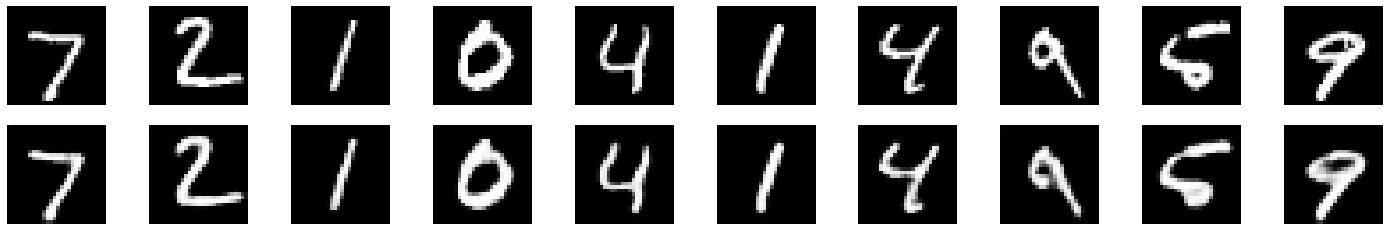

In [9]:
# sample output of the autoencoder
dataiter = iter(test_loader)
images, _ = dataiter.next()
outputs = model(images)

imgs = images.numpy() 
out = outputs.detach().numpy()

fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (25, 4))
for row in range(2):
    if row == 0:
        im = imgs
    else:
        im = out
    for col in range(10):
        ax[row, col].imshow(np.squeeze(im[col]), cmap = 'gray')
        ax[row, col].axis('off')
plt.show()        

The images produces by the autoencoder look pretty good!